In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings("ignore")

#### ПОСТАНОВКА ЗАДАЧИ

К вам попали результаты A/A/B-тестирования от одного известного маркетплейса. 

sample_a, sample_c — АА-группы, sample_b — отдельная группа. 

В каждом датасете есть три типа действий пользователей: 0 — клик, 1 — просмотр и 2 — покупка (пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

ctr (отношение кликов к просмотрам товаров);

purchase rate (отношение покупок к просмотрам товаров);

gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).


Данные уже почищены по сессиям, вы можете использовать их в агрегированном виде. Ваша задача — понять, нет ли проблемы с разъезжанием сплитов и улучшает ли алгоритм B работу маркетплейса.

In [2]:
sample_a = pd.read_csv("./data/sample_a.csv")
sample_b = pd.read_csv("./data/sample_b.csv")
sample_c = pd.read_csv("./data/sample_c.csv")

# Посмотрим на таблицы
display(
    sample_a.sample(7),
    sample_b.sample(7),
    sample_c.sample(7)
)

# И размер
print(
    "Shape of datasets:",
    sample_a.shape,
    sample_b.shape,
    sample_c.shape
)

# Сразу же посмотрим на наличие дубликатов
print(
    sample_a[sample_a.duplicated()].value_counts(),
    sample_b[sample_b.duplicated()].value_counts(),
    sample_c[sample_c.duplicated()].value_counts()
)

# И на количество уникальных пользователей и товаров
print(
    f"Unique users/items in samle_a: {sample_a['user_id'].nunique()} / {sample_a['item_id'].nunique()}\n",
    f"Unique users/items in samle_b: {sample_b['user_id'].nunique()} / {sample_b['item_id'].nunique()}\n",
    f"Unique users/items in samle_c: {sample_c['user_id'].nunique()} / {sample_c['item_id'].nunique()}\n",
)

,user_id,item_id,action_id
151295,63202,87,1
1116572,69673,3324,1
653580,63622,2236,1
296513,93785,7526,0
16165,22450,5552,1
982702,54349,6476,1
654090,89340,9802,1


,user_id,item_id,action_id
881219,107416,9643,1
674032,120742,8541,1
982150,120855,9802,2
1084267,157211,500,1
260919,158950,3627,1
418065,172596,3874,0
1030546,141990,8767,1


,user_id,item_id,action_id
855643,251401,1569,1
206660,255133,606,1
666346,244979,9903,1
926510,267939,5241,1
832963,205508,2238,0
585285,298935,5556,1
1086750,246987,7341,1


Shape of datasets: (1188912, 3) (1198438, 3) (1205510, 3)
Series([], Name: count, dtype: int64) Series([], Name: count, dtype: int64) Series([], Name: count, dtype: int64)
Unique users/items in samle_a: 996 / 955
 Unique users/items in samle_b: 996 / 955
 Unique users/items in samle_c: 994 / 955



> Дубликатов нет.

> Выборки сбалансированны по количеству и по товарам.

> Всего было показано 955 уникальных товара.

In [3]:
# Вытащим цены
prices = pd.read_csv("./data/item_prices.csv")
prices.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


---
#### Проверим логические ошибки

In [4]:
# Перекодируем действия и вытащим dummies
sample_a["action_id"] = sample_a["action_id"].map({0:"click", 1:"view", 2:"purchase"})
sample_a = pd.get_dummies(sample_a, dtype=int)

sample_b["action_id"] = sample_b["action_id"].map({0:"click", 1:"view", 2:"purchase"})
sample_b = pd.get_dummies(sample_b, dtype=int)

sample_c["action_id"] = sample_c["action_id"].map({0:"click", 1:"view", 2:"purchase"})
sample_c = pd.get_dummies(sample_c, dtype=int)

display(
    sample_a.head(),
    sample_b.head(),
    sample_c.head()
)

,user_id,item_id,action_id_click,action_id_purchase,action_id_view
0,84636,360,0,0,1
1,21217,9635,0,0,1
2,13445,8590,0,0,1
3,38450,5585,0,0,1
4,14160,2383,1,0,0


,user_id,item_id,action_id_click,action_id_purchase,action_id_view
0,118375,4105,0,0,1
1,107569,8204,0,0,1
2,175990,880,0,0,1
3,160582,9568,1,0,0
4,123400,4000,0,0,1


,user_id,item_id,action_id_click,action_id_purchase,action_id_view
0,274623,2863,0,0,1
1,265472,343,0,0,1
2,242779,6009,1,0,0
3,275009,2184,0,0,1
4,268104,3134,0,1,0


In [5]:
# Создадим временный флаг проверяющий была ли совершена покупка без клика или просмотра
test_a = sample_a.groupby(by=["user_id", "item_id"]).sum()
test_a["error"] = test_a["action_id_click"] + test_a["action_id_view"] - test_a["action_id_purchase"]

test_b = sample_b.groupby(by=["user_id", "item_id"]).sum()
test_b["error"] = test_b["action_id_click"] + test_b["action_id_view"] - test_b["action_id_purchase"]

test_c = sample_c.groupby(by=["user_id", "item_id"]).sum()
test_c["error"] = test_c["action_id_click"] + test_c["action_id_view"] - test_c["action_id_purchase"]

In [6]:
# Проверим наличие элементов с флагом -1 (покупка без клика и просмотра)
display(
    test_a[test_a["error"] < 0],
    test_b[test_b["error"] < 0],
    test_c[test_c["error"] < 0]
)

,,action_id_click,action_id_purchase,action_id_view,error
user_id,item_id,,,,


,,action_id_click,action_id_purchase,action_id_view,error
user_id,item_id,,,,


,,action_id_click,action_id_purchase,action_id_view,error
user_id,item_id,,,,


> Как можно видеть датасеты удовлетворяют этому условию.

In [7]:
# Приделаем цену для вывода в дальнейшем суммы покупок
sample_a = pd.merge(left=sample_a, right=prices, left_on="item_id", right_on="item_id")
sample_b = pd.merge(left=sample_b, right=prices, left_on="item_id", right_on="item_id")
sample_c = pd.merge(left=sample_c, right=prices, left_on="item_id", right_on="item_id")

display(
    sample_a.head(),
    sample_b.head(),
    sample_c.head()
)

,user_id,item_id,action_id_click,action_id_purchase,action_id_view,item_price
0,84636,360,0,0,1,1896
1,21217,9635,0,0,1,1699
2,13445,8590,0,0,1,846
3,38450,5585,0,0,1,1556
4,14160,2383,1,0,0,1956


,user_id,item_id,action_id_click,action_id_purchase,action_id_view,item_price
0,118375,4105,0,0,1,536
1,107569,8204,0,0,1,1569
2,175990,880,0,0,1,846
3,160582,9568,1,0,0,1388
4,123400,4000,0,0,1,268


,user_id,item_id,action_id_click,action_id_purchase,action_id_view,item_price
0,274623,2863,0,0,1,1283
1,265472,343,0,0,1,1196
2,242779,6009,1,0,0,1184
3,275009,2184,0,0,1,225
4,268104,3134,0,1,0,162


In [8]:
# Выведем колонку суммы покупки
sample_a["purchase"] = sample_a["action_id_purchase"] * sample_a["item_price"]
sample_b["purchase"] = sample_b["action_id_purchase"] * sample_b["item_price"]
sample_c["purchase"] = sample_c["action_id_purchase"] * sample_c["item_price"]

display(
    sample_a.head(),
    sample_b.head(),
    sample_c.head()
)

,user_id,item_id,action_id_click,action_id_purchase,action_id_view,item_price,purchase
0,84636,360,0,0,1,1896,0
1,21217,9635,0,0,1,1699,0
2,13445,8590,0,0,1,846,0
3,38450,5585,0,0,1,1556,0
4,14160,2383,1,0,0,1956,0


,user_id,item_id,action_id_click,action_id_purchase,action_id_view,item_price,purchase
0,118375,4105,0,0,1,536,0
1,107569,8204,0,0,1,1569,0
2,175990,880,0,0,1,846,0
3,160582,9568,1,0,0,1388,0
4,123400,4000,0,0,1,268,0


,user_id,item_id,action_id_click,action_id_purchase,action_id_view,item_price,purchase
0,274623,2863,0,0,1,1283,0
1,265472,343,0,0,1,1196,0
2,242779,6009,1,0,0,1184,0
3,275009,2184,0,0,1,225,0
4,268104,3134,0,1,0,162,162


---
#### Посмотрим на распределений.

In [9]:
sample_a = (
    sample_a.groupby(by="user_id")
    .sum()
    .reset_index()
    .drop(["item_id", "item_price"], axis=1)
)
sample_b = (
    sample_b.groupby(by="user_id")
    .sum()
    .reset_index()
    .drop(["item_id", "item_price"], axis=1)
)
sample_c = (
    sample_c.groupby(by="user_id")
    .sum()
    .reset_index()
    .drop(["item_id", "item_price"], axis=1)
)

In [10]:
# Переименуем нормально колонки
sample_a.rename(
    columns={
        "action_id_click": "click_num",
        "action_id_purchase": "purchase_num",
        "action_id_view": "view_num",
        "purchase": "purchase_sum",
    },
    inplace=True,
)

sample_b.rename(
    columns={
        "action_id_click": "click_num",
        "action_id_purchase": "purchase_num",
        "action_id_view": "view_num",
        "purchase": "purchase_sum",
    },
    inplace=True,
)

sample_c.rename(
    columns={
        "action_id_click": "click_num",
        "action_id_purchase": "purchase_num",
        "action_id_view": "view_num",
        "purchase": "purchase_sum",
    },
    inplace=True,
)

In [11]:
display(
    sample_a.head(),
    sample_b.head(),
    sample_c.head()
)

,user_id,click_num,purchase_num,view_num,purchase_sum
0,241,186,48,1000,48232
1,253,201,37,1000,38676
2,362,186,52,1000,61392
3,378,206,53,1000,60223
4,475,209,54,1000,53476


,user_id,click_num,purchase_num,view_num,purchase_sum
0,100038,176,104,1000,106996
1,100099,169,123,1000,133374
2,100164,153,101,1000,103207
3,100321,187,99,1000,103841
4,100397,159,86,1000,95020


,user_id,click_num,purchase_num,view_num,purchase_sum
0,200225,206,50,1000,51077
1,200278,213,60,1000,58453
2,200282,218,73,1000,86997
3,200325,194,47,1000,51910
4,200441,212,51,999,53939


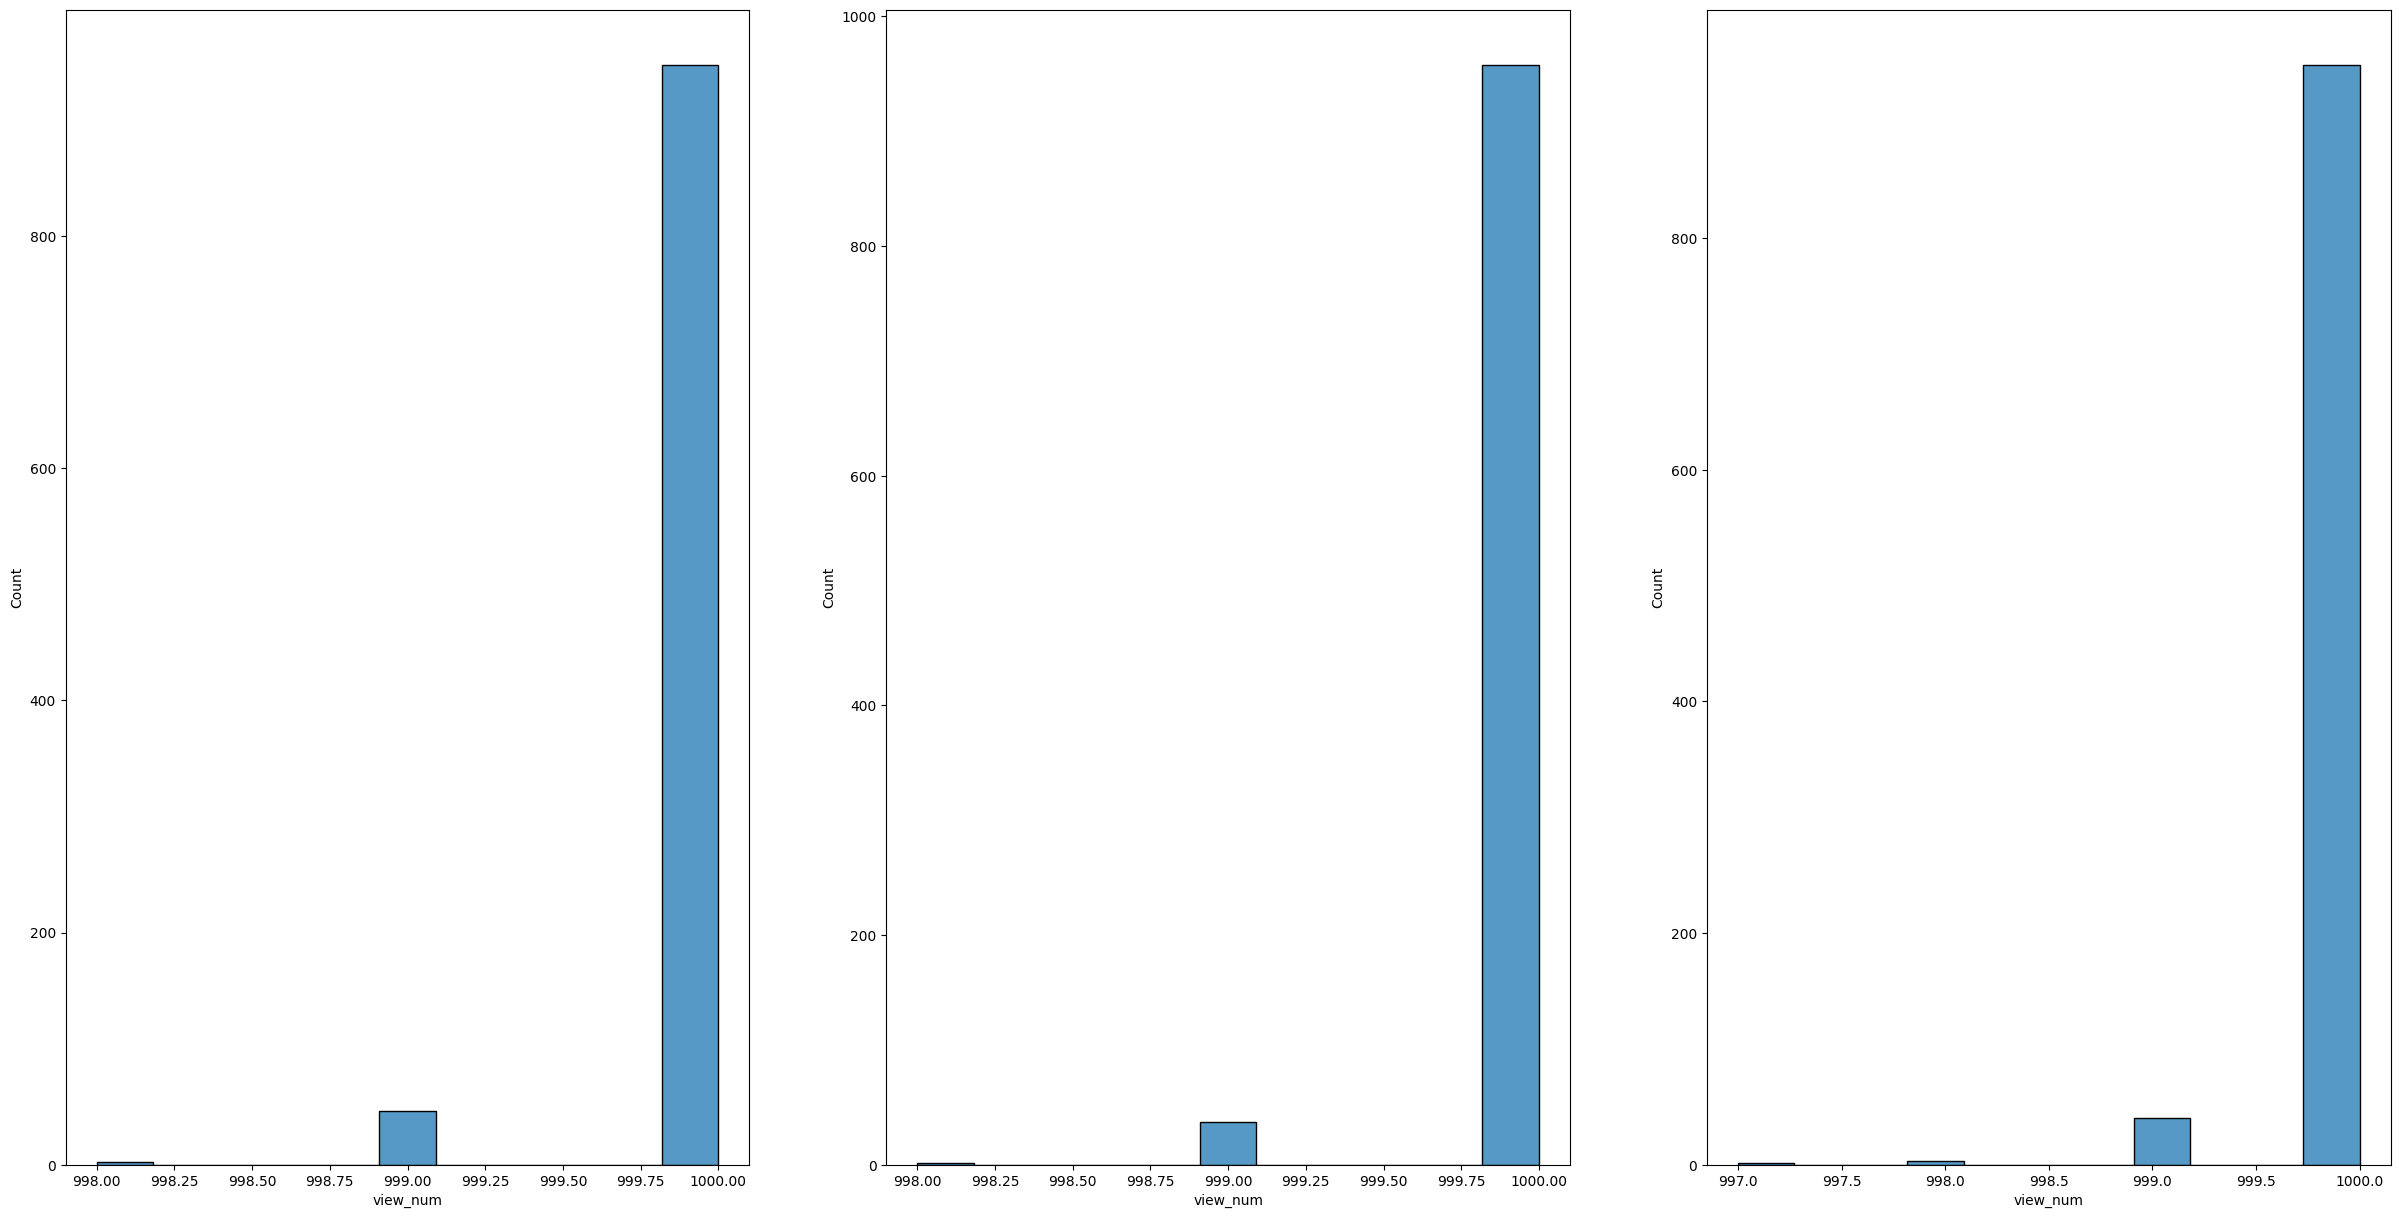

In [12]:
# Ради интереса посмотрим сколько товаров в каждой выборке были просмотрены
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=sample_a["view_num"], ax=axes[0])

sns.histplot(data=sample_b["view_num"], ax=axes[1])

sns.histplot(data=sample_c["view_num"], ax=axes[2])

plt.show()

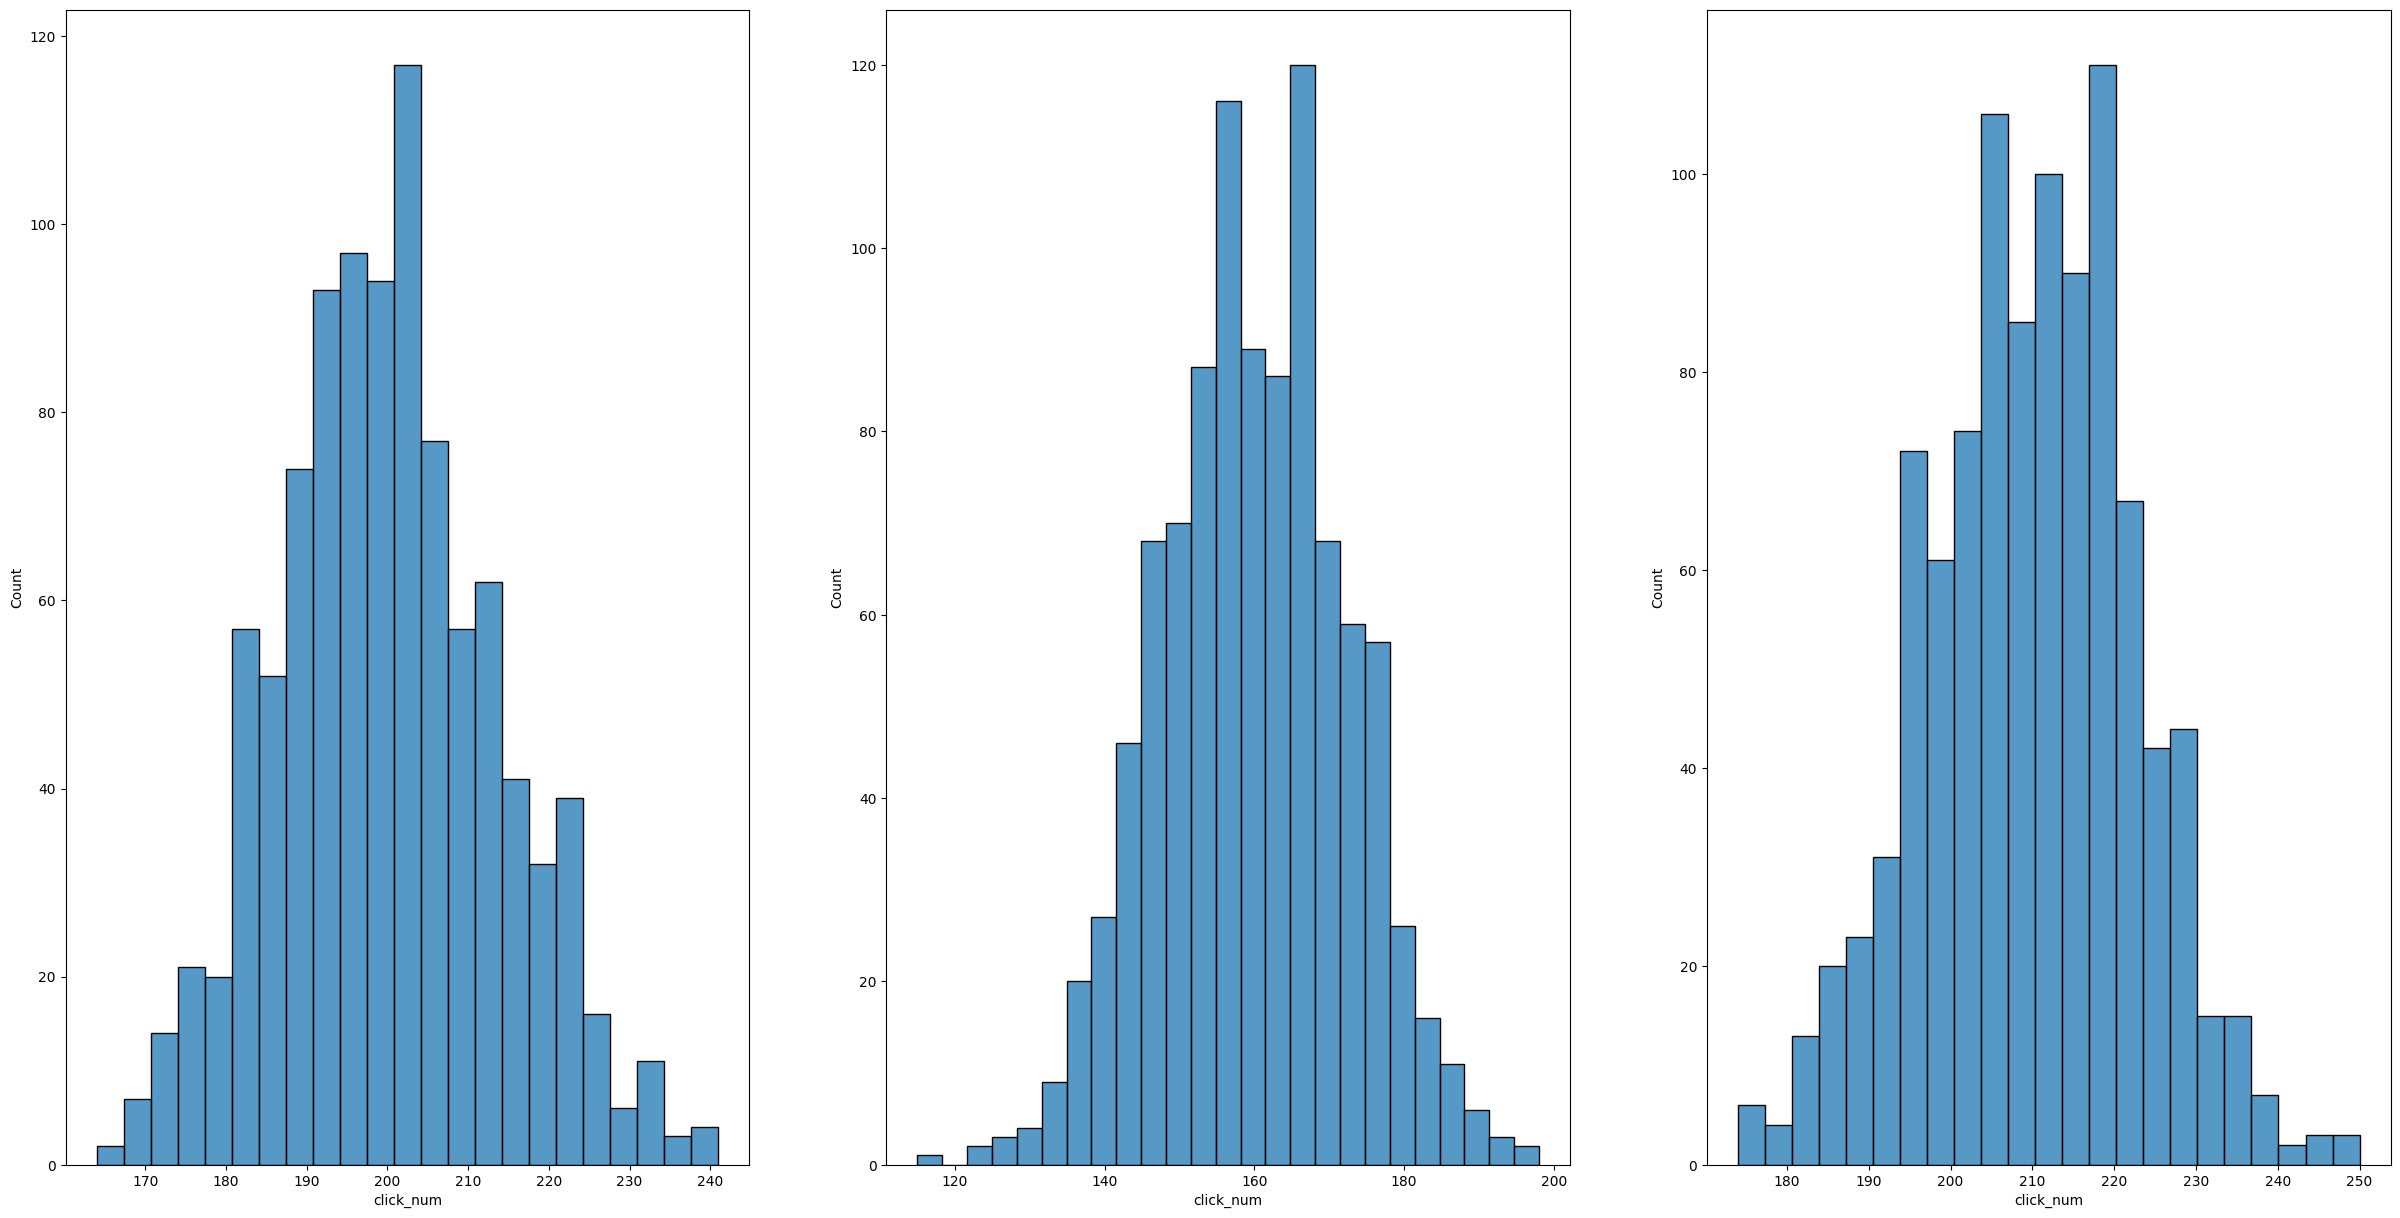

In [13]:
# Посмотрим сколько товаров в каждой выборке были кликнуты
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=sample_a["click_num"], ax=axes[0])

sns.histplot(data=sample_b["click_num"], ax=axes[1])

sns.histplot(data=sample_c["click_num"], ax=axes[2])

plt.show()

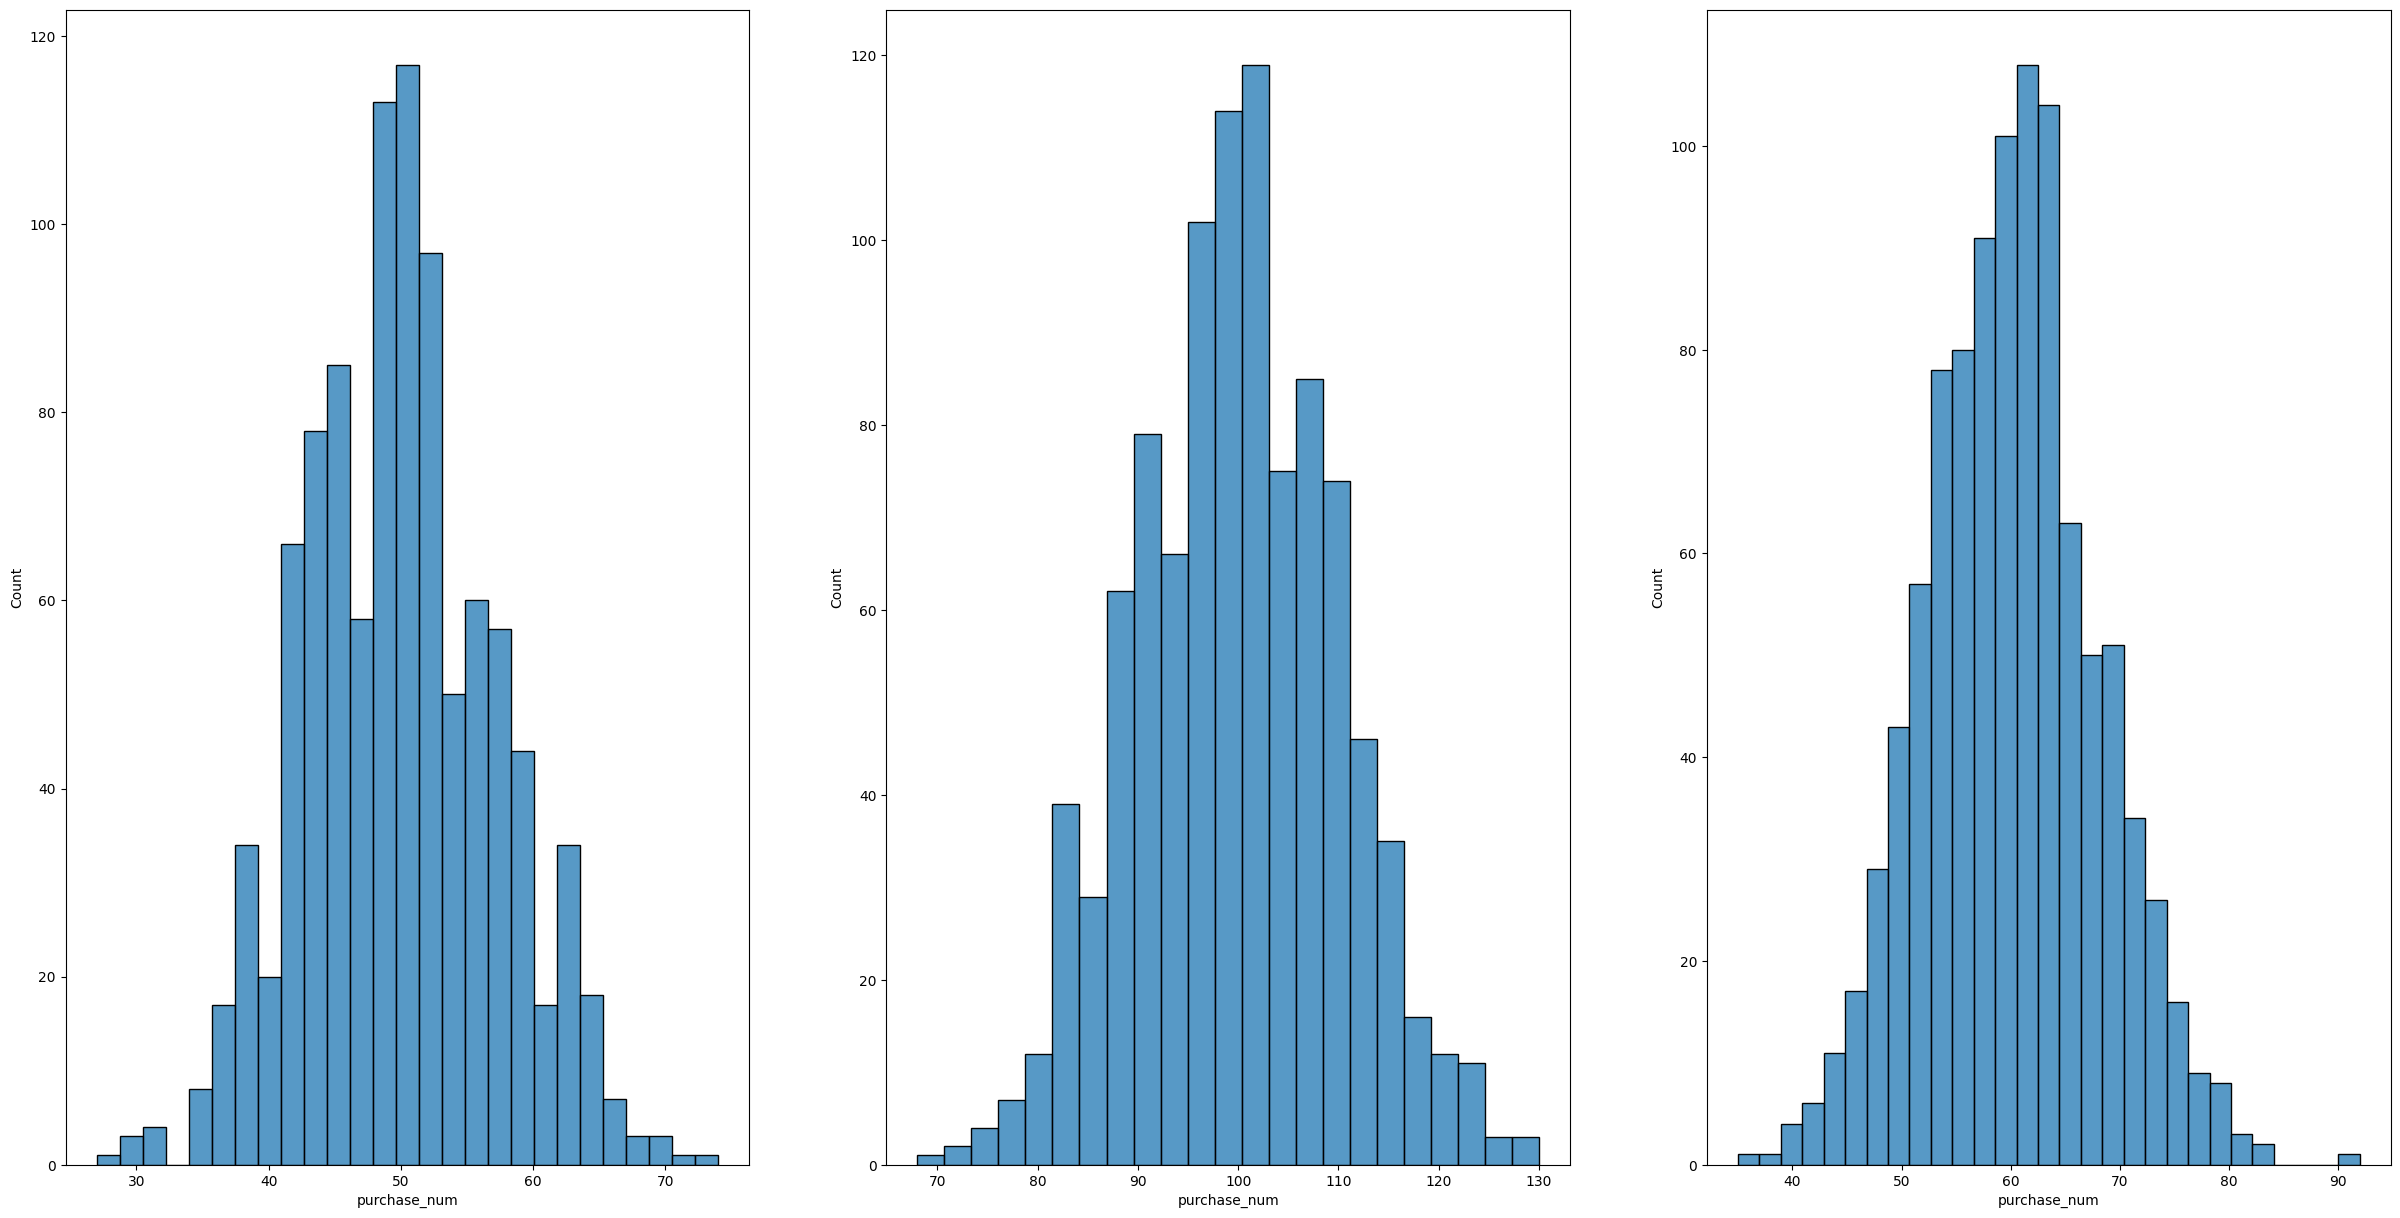

In [14]:
# Сколько товаров в каждой выборке были куплены
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=sample_a["purchase_num"], ax=axes[0])

sns.histplot(data=sample_b["purchase_num"], ax=axes[1])

sns.histplot(data=sample_c["purchase_num"], ax=axes[2])

plt.show()

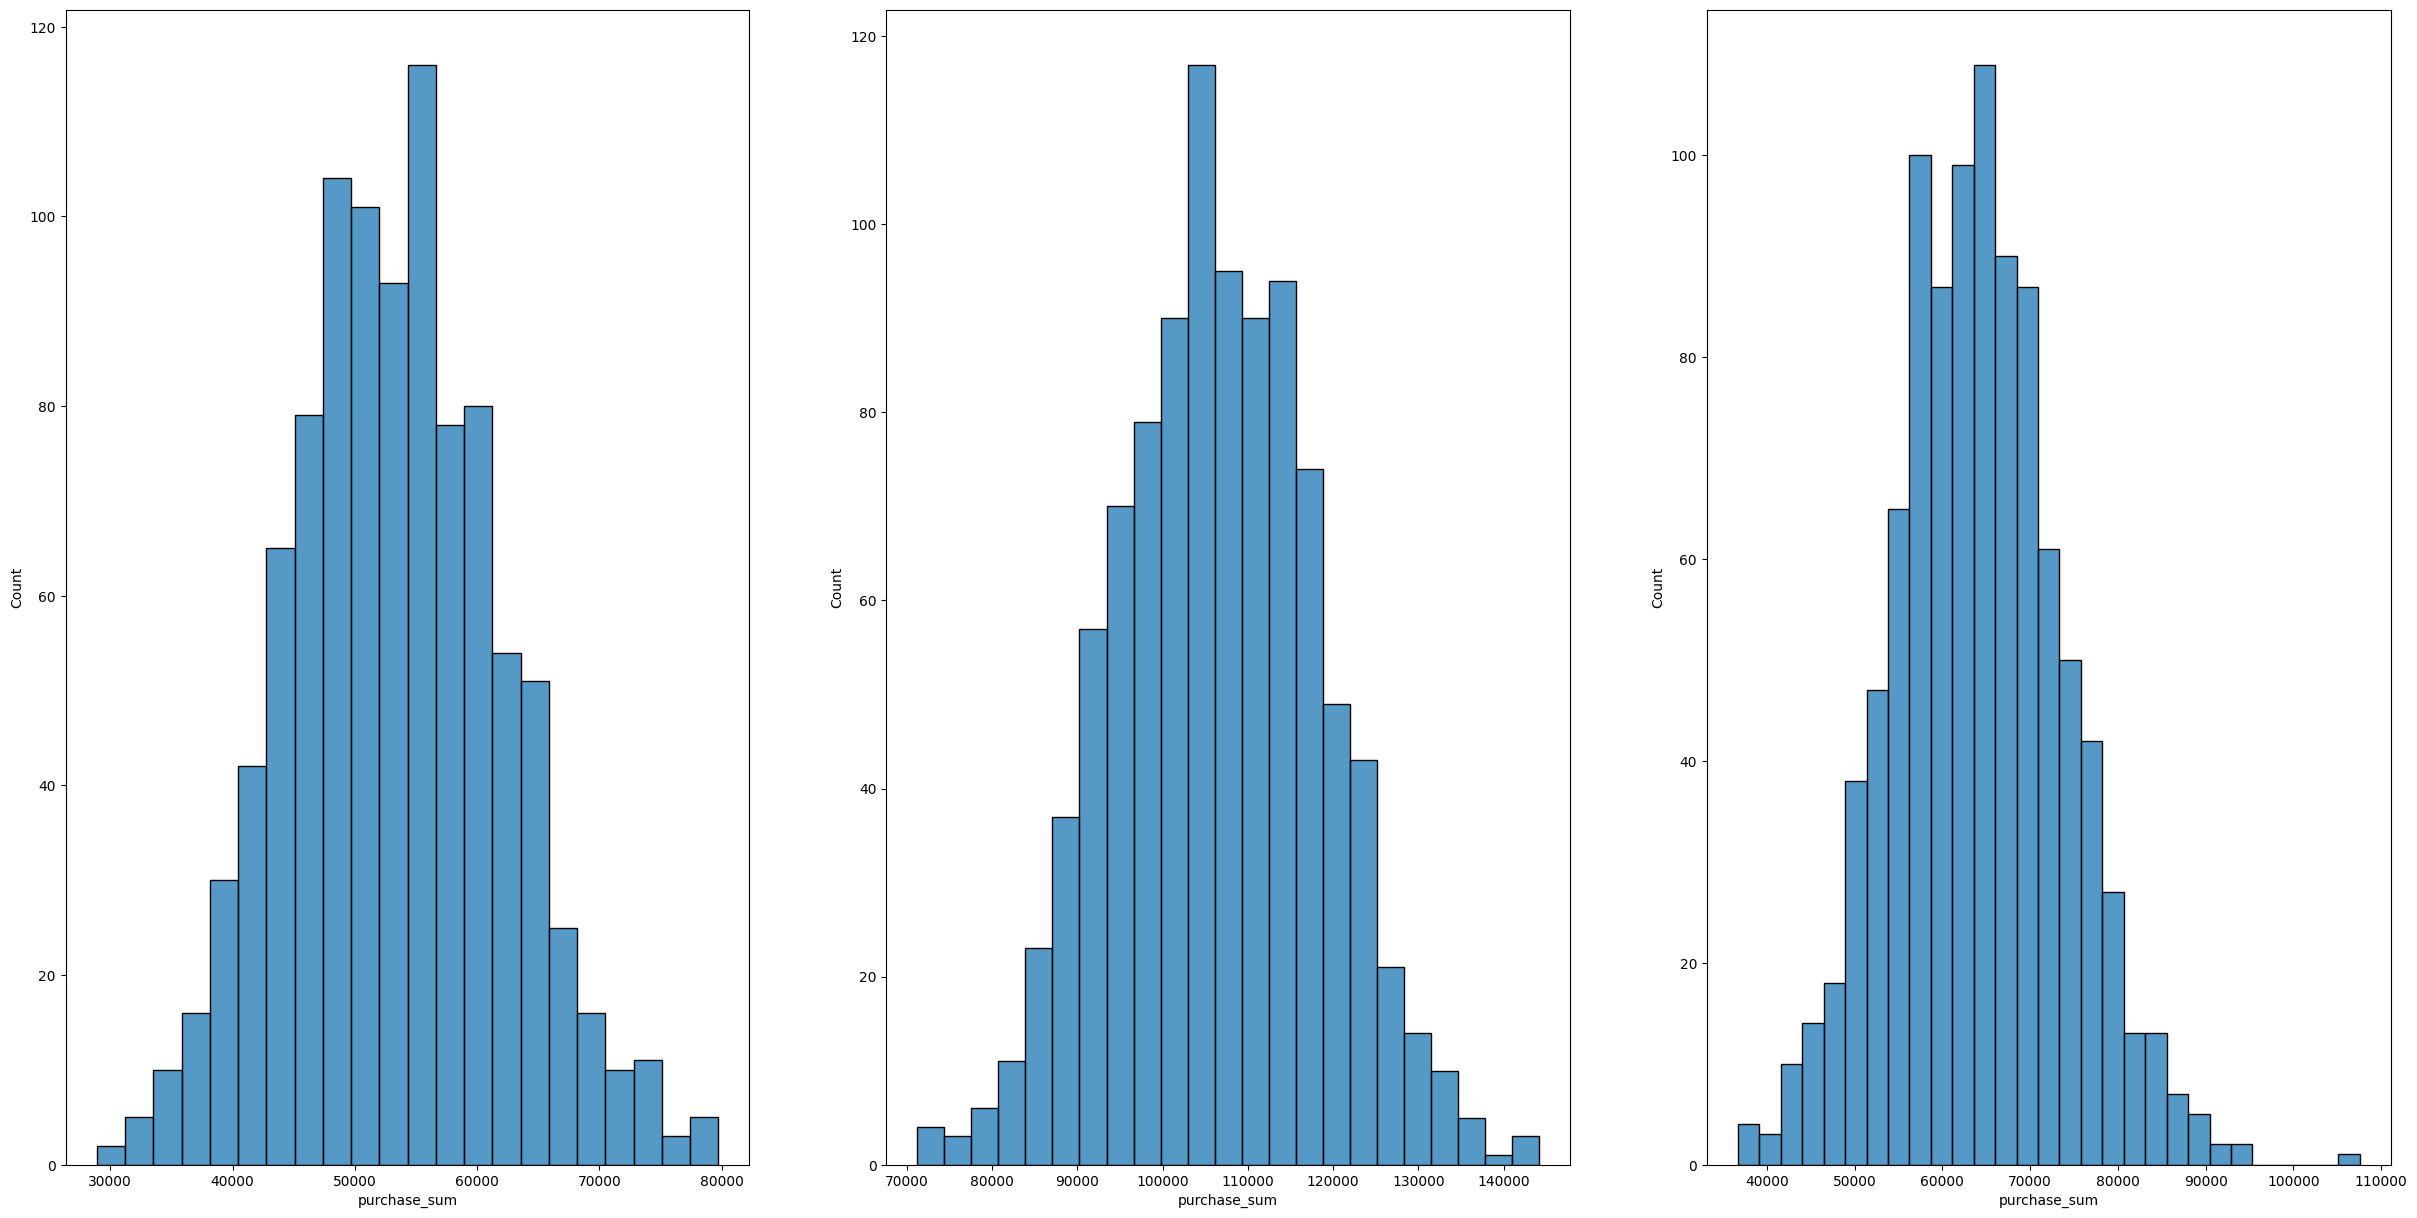

In [15]:
# Распределение сумм покупок
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=sample_a["purchase_sum"], ax=axes[0])

sns.histplot(data=sample_b["purchase_sum"], ax=axes[1])

sns.histplot(data=sample_c["purchase_sum"], ax=axes[2])

plt.show()

#### Проверим статтестом на нормальность всех распределений

In [16]:
# Функция для теста на нормальность
def shapiro_test(x, alpha = 0.05, name_feat=""):
    _, p_value = shapiro(x=x)
    
    if p_value <= alpha:
        print(f"{name_feat} не нормальное распределение")
    else:
        print(f"{name_feat} нормальное распределение")

In [17]:
check_columns = ["click_num", "purchase_num", "purchase_sum"]

# Для sample_a
for i in check_columns:
    shapiro_test(x=sample_a[i], name_feat=i)

click_num не нормальное распределение
purchase_num не нормальное распределение
purchase_sum нормальное распределение


In [18]:
# Для sample_b
for i in check_columns:
    shapiro_test(x=sample_b[i], name_feat=i)

click_num нормальное распределение
purchase_num нормальное распределение
purchase_sum нормальное распределение


In [19]:
# Для sample_c
for i in check_columns:
    shapiro_test(x=sample_c[i], name_feat=i)

click_num нормальное распределение
purchase_num нормальное распределение
purchase_sum не нормальное распределение


> В каждой выборке были просмотрены все товары всеми пользователями из имеющегося спектра.

> Распределения переменных между a и c (AA сплиты) сплитами по фитам не всегда соответсвуют нормальному, что требует рассмотрения гипотезы, что наши отладочные группы различны и весь ABA тест не корректен.

> Распределение всех фитов на сплите b (treat-сплите) нормальное.


---
#### Выведем для каждого сета бизнес метрики.

> 

In [20]:
# По-сути у нас уже есть GMV (Gross Merchandise Volume), он лежит в purchase_sum
sample_a.rename(columns={"purchase_sum":"gmv"}, inplace=True)
sample_b.rename(columns={"purchase_sum":"gmv"}, inplace=True)
sample_c.rename(columns={"purchase_sum":"gmv"}, inplace=True)

In [21]:
# ctr (отношение кликов к просмотрам товаров)
sample_a["ctr"] = sample_a["click_num"] / sample_a["view_num"]
sample_b["ctr"] = sample_b["click_num"] / sample_b["view_num"]
sample_c["ctr"] = sample_c["click_num"] / sample_c["view_num"]

In [22]:
# purchase rate (отношение покупок к просмотрам товаров)
sample_a["purchase_rate"] = sample_a["purchase_num"] / sample_a["view_num"]
sample_b["purchase_rate"] = sample_b["purchase_num"] / sample_b["view_num"]
sample_c["purchase_rate"] = sample_c["purchase_num"] / sample_c["view_num"]

In [23]:
# Выделим фреймы для работы 
bach_a = sample_a.copy()
bach_b = sample_b.copy()
bach_c = sample_c.copy()

bach_a = bach_a[["ctr", "purchase_rate", "gmv"]]
bach_b = bach_b[["ctr", "purchase_rate", "gmv"]]
bach_c = bach_c[["ctr", "purchase_rate", "gmv"]]

In [24]:
display(
    bach_a.head(),
    bach_b.head(),
    bach_c.head()
)

,ctr,purchase_rate,gmv
0,0.186,0.048,48232
1,0.201,0.037,38676
2,0.186,0.052,61392
3,0.206,0.053,60223
4,0.209,0.054,53476


,ctr,purchase_rate,gmv
0,0.176,0.104,106996
1,0.169,0.123,133374
2,0.153,0.101,103207
3,0.187,0.099,103841
4,0.159,0.086,95020


,ctr,purchase_rate,gmv
0,0.206000,0.050000,51077
1,0.213000,0.060000,58453
2,0.218000,0.073000,86997
3,0.194000,0.047000,51910
4,0.212212,0.051051,53939


In [25]:
display(
    bach_a.describe(),
    bach_b.describe(),
    bach_c.describe()
)

,ctr,purchase_rate,gmv
count,996.000000,996.000000,996.000000
mean,0.200063,0.049950,53273.270080
std,0.013438,0.007228,8573.875661
min,0.164000,0.027000,28890.000000
25%,0.191000,0.045000,47413.500000
50%,0.199100,0.050000,52892.000000
75%,0.208406,0.054014,59091.500000
max,0.241000,0.074000,79722.000000


,ctr,purchase_rate,gmv
count,996.000000,996.000000,996.000000
mean,0.159940,0.099875,106473.271084
std,0.012485,0.009996,11838.455338
min,0.115000,0.068000,71245.000000
25%,0.151151,0.093000,98393.750000
50%,0.160000,0.100000,106192.000000
75%,0.168000,0.107000,114606.500000
max,0.198000,0.130000,144133.000000


,ctr,purchase_rate,gmv
count,994.000000,994.000000,994.000000
mean,0.209952,0.060052,63998.903421
std,0.012651,0.007992,9562.844625
min,0.174000,0.035000,36694.000000
25%,0.201000,0.055000,57542.250000
50%,0.211000,0.060000,63816.000000
75%,0.218000,0.065000,69937.500000
max,0.250000,0.092000,107534.000000


> Можно отметить смещение сильное среднего значения по gmv в сплите В, что предварительно может нам говорит о вероятном эффекте на treatment выборке, а значит и о положительном эффекте от внедрения функционала или что там у нас.

> Остальные метрики имеют плюс минус схожие разбросы по статистикам. Можно было бы посмотреть наличие выбросов.

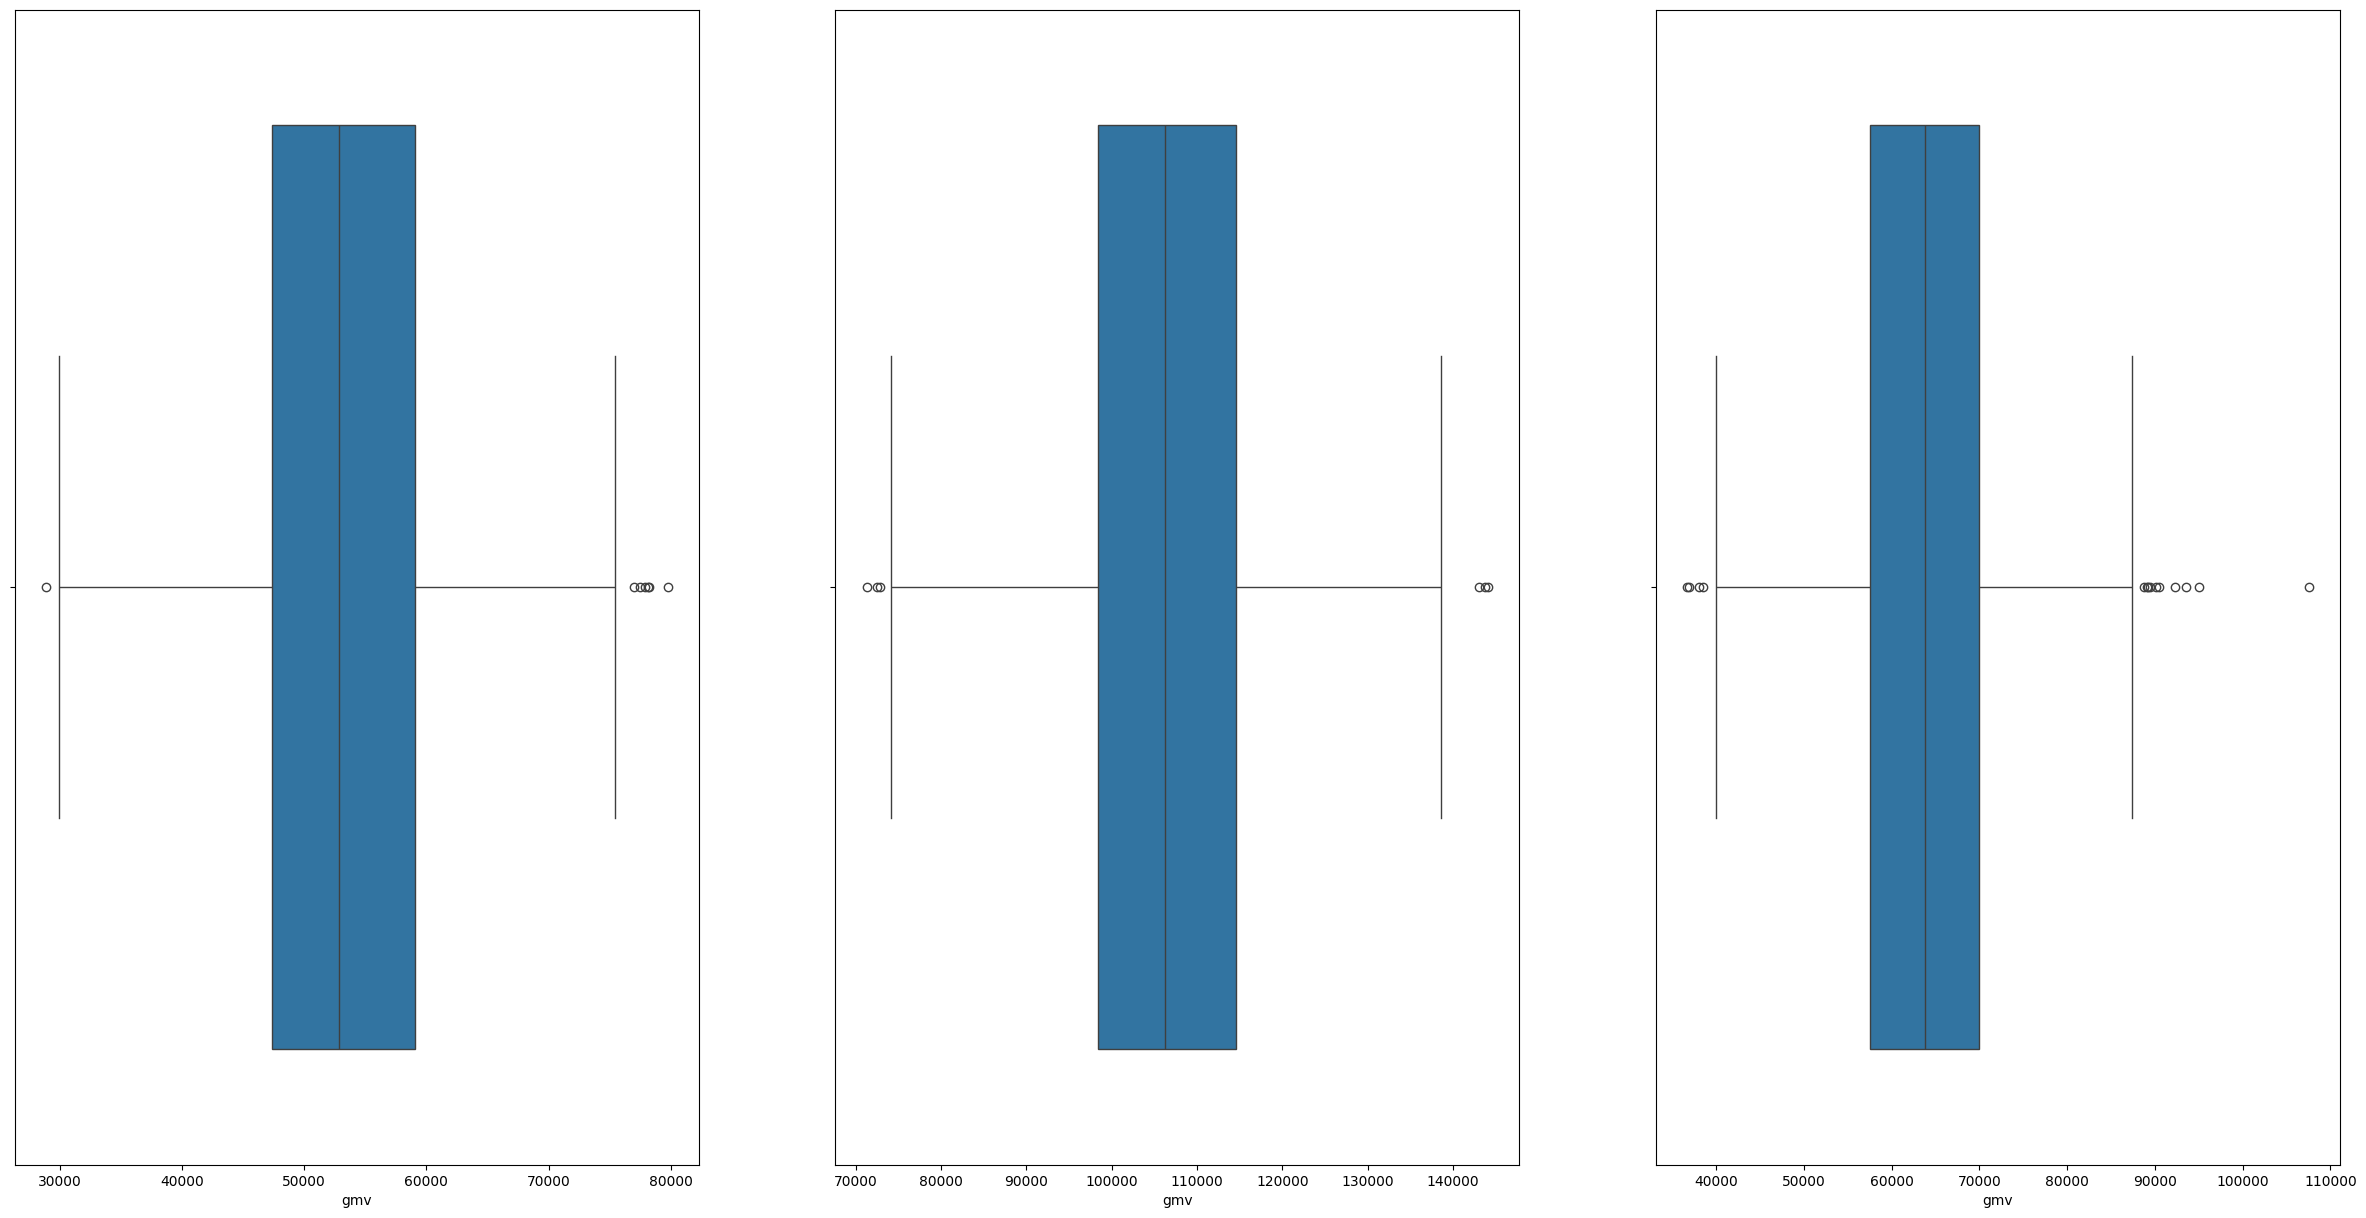

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(30,15))

sns.boxplot(data=bach_a, x="gmv", ax=axes[0])
sns.boxplot(data=bach_b, x="gmv", ax=axes[1])
sns.boxplot(data=bach_c, x="gmv", ax=axes[2])
plt.show()

> Судя по всему на смещение среднего по В обусловленно не выбросами. Но все равно почистим их во всех сплитах.

> Ранее мы уже указали что распределения gmv нормально на всех сплитах кроме С (но визуально там оно весьма близко к нормальному)

In [27]:
# Наша старая функция с первого года.
def outliers_z_score(data, feature, left_mod=2, right_mod=2, log_scale=False):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]

    mu = x.mean()

    sigma = x.std()

    lower_bound = mu - left_mod * sigma

    upper_bound = mu + right_mod * sigma

    outliers = data[(x < lower_bound) | (x > upper_bound)]

    cleaned = data[(x > lower_bound) & (x < upper_bound)]

    print(f"Number of outliers by z-method: {outliers.shape[0]}")
    print(f"Resulting number of lines cleared of outliers: {cleaned.shape[0]}")

    return outliers, cleaned

In [28]:
_, cleaned_a = outliers_z_score(bach_a, "gmv")
_, cleaned_b = outliers_z_score(bach_b, "gmv")
_, cleaned_c = outliers_z_score(bach_c, "gmv")

Number of outliers by z-method: 51
Resulting number of lines cleared of outliers: 945
Number of outliers by z-method: 45
Resulting number of lines cleared of outliers: 951
Number of outliers by z-method: 50
Resulting number of lines cleared of outliers: 944


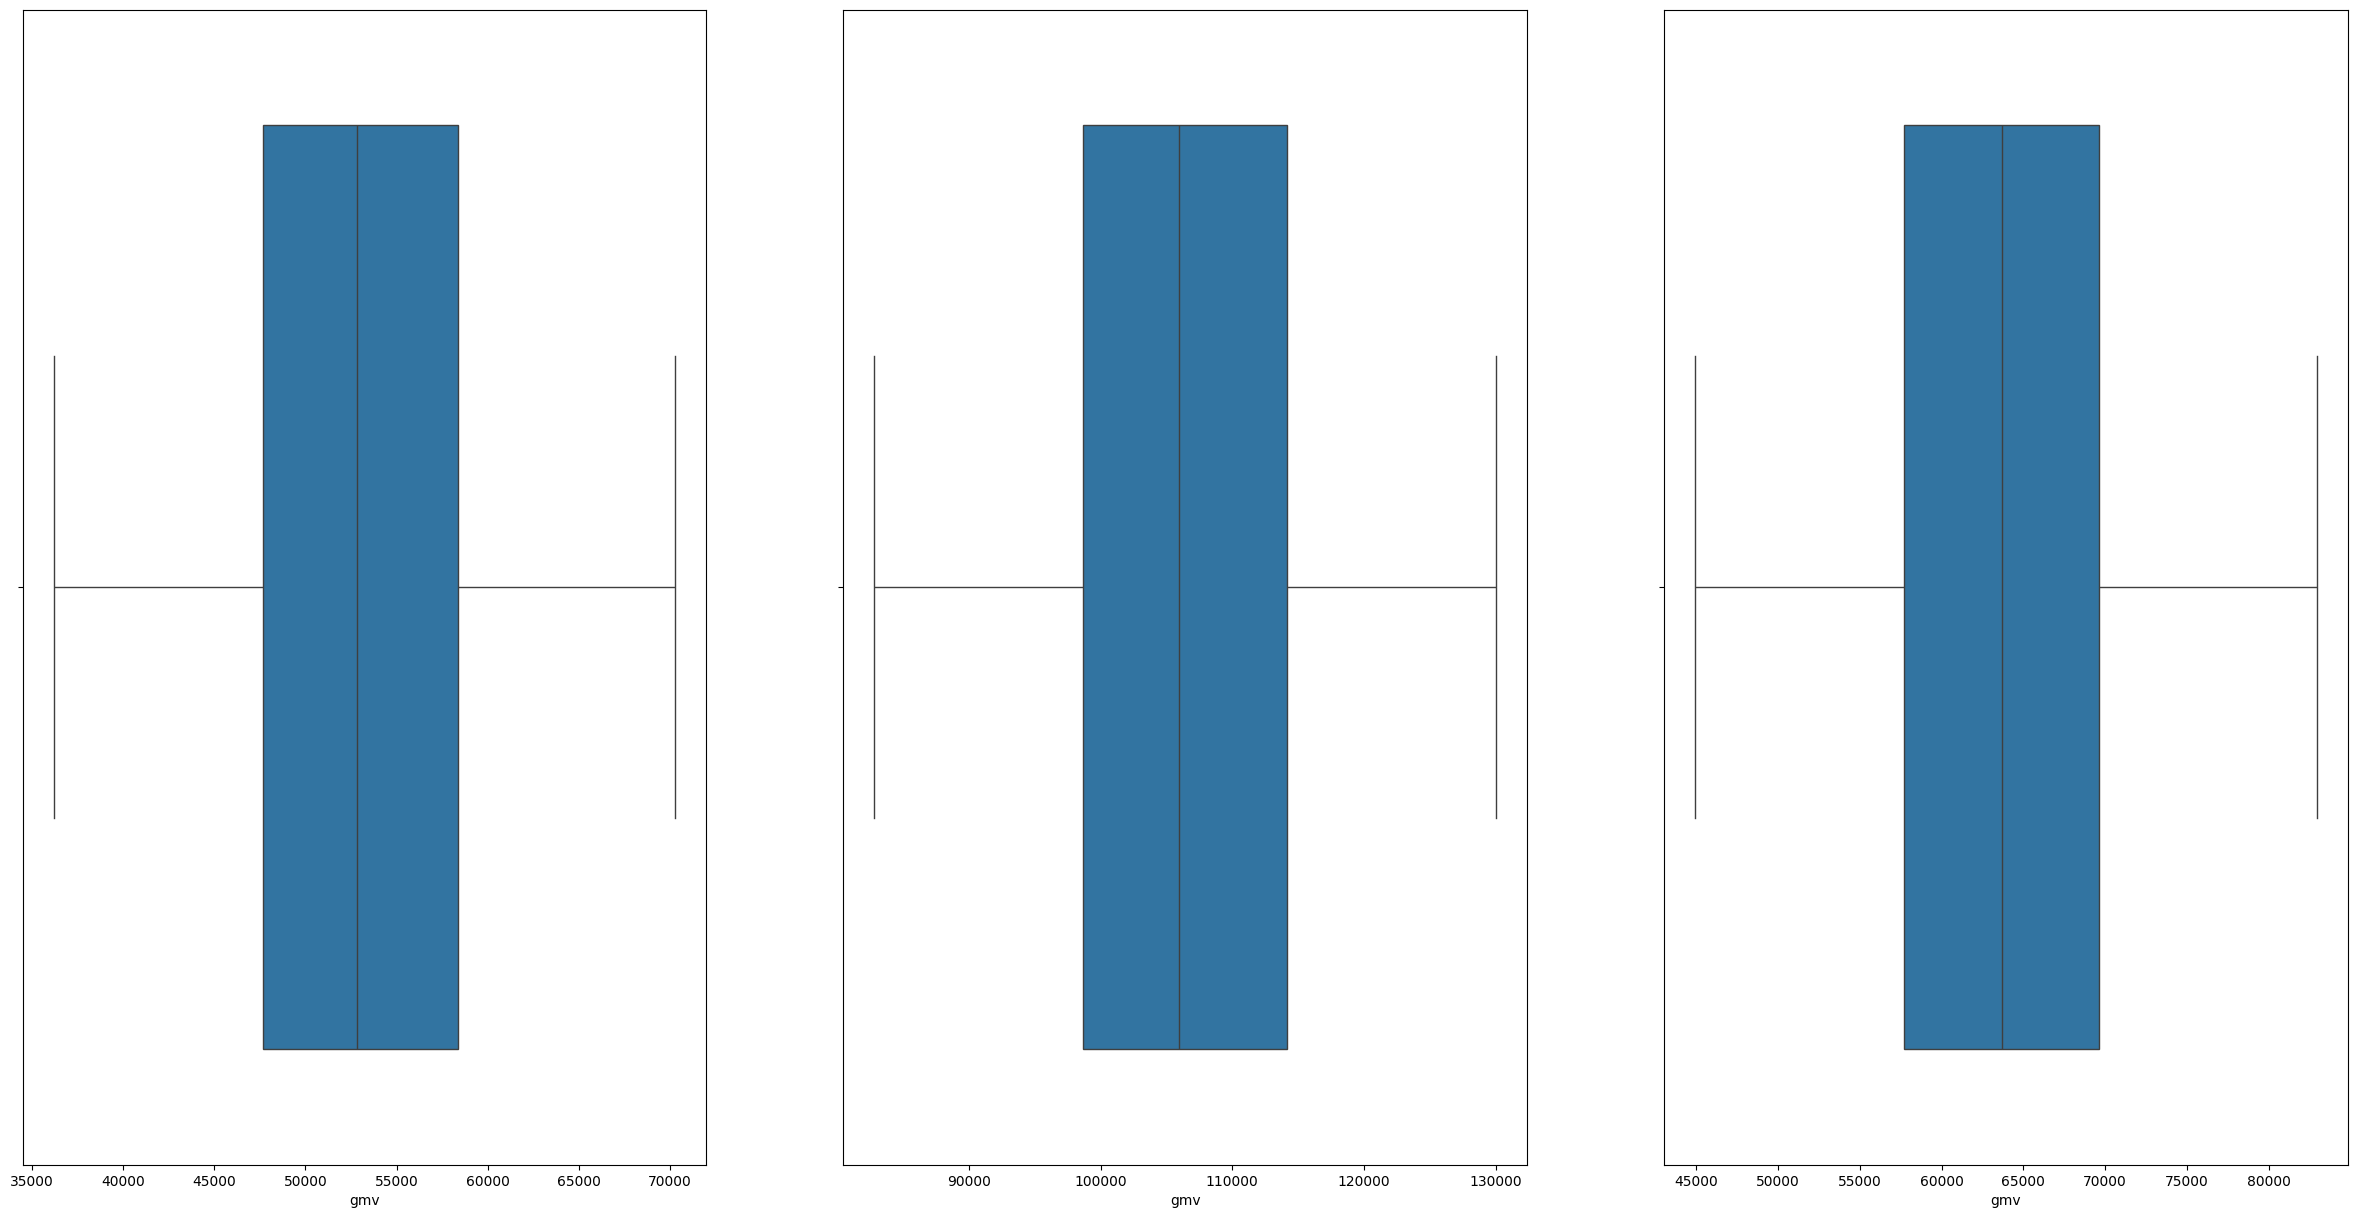

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(30,15))

sns.boxplot(data=cleaned_a, x="gmv", ax=axes[0])
sns.boxplot(data=cleaned_b, x="gmv", ax=axes[1])
sns.boxplot(data=cleaned_c, x="gmv", ax=axes[2])
plt.show()

In [30]:
check_columns = ["ctr", "purchase_rate", "gmv"]

# Проверим распределения после очистки для sample_a
for i in check_columns:
    shapiro_test(x=cleaned_a[i], name_feat=i)

ctr не нормальное распределение
purchase_rate не нормальное распределение
gmv не нормальное распределение


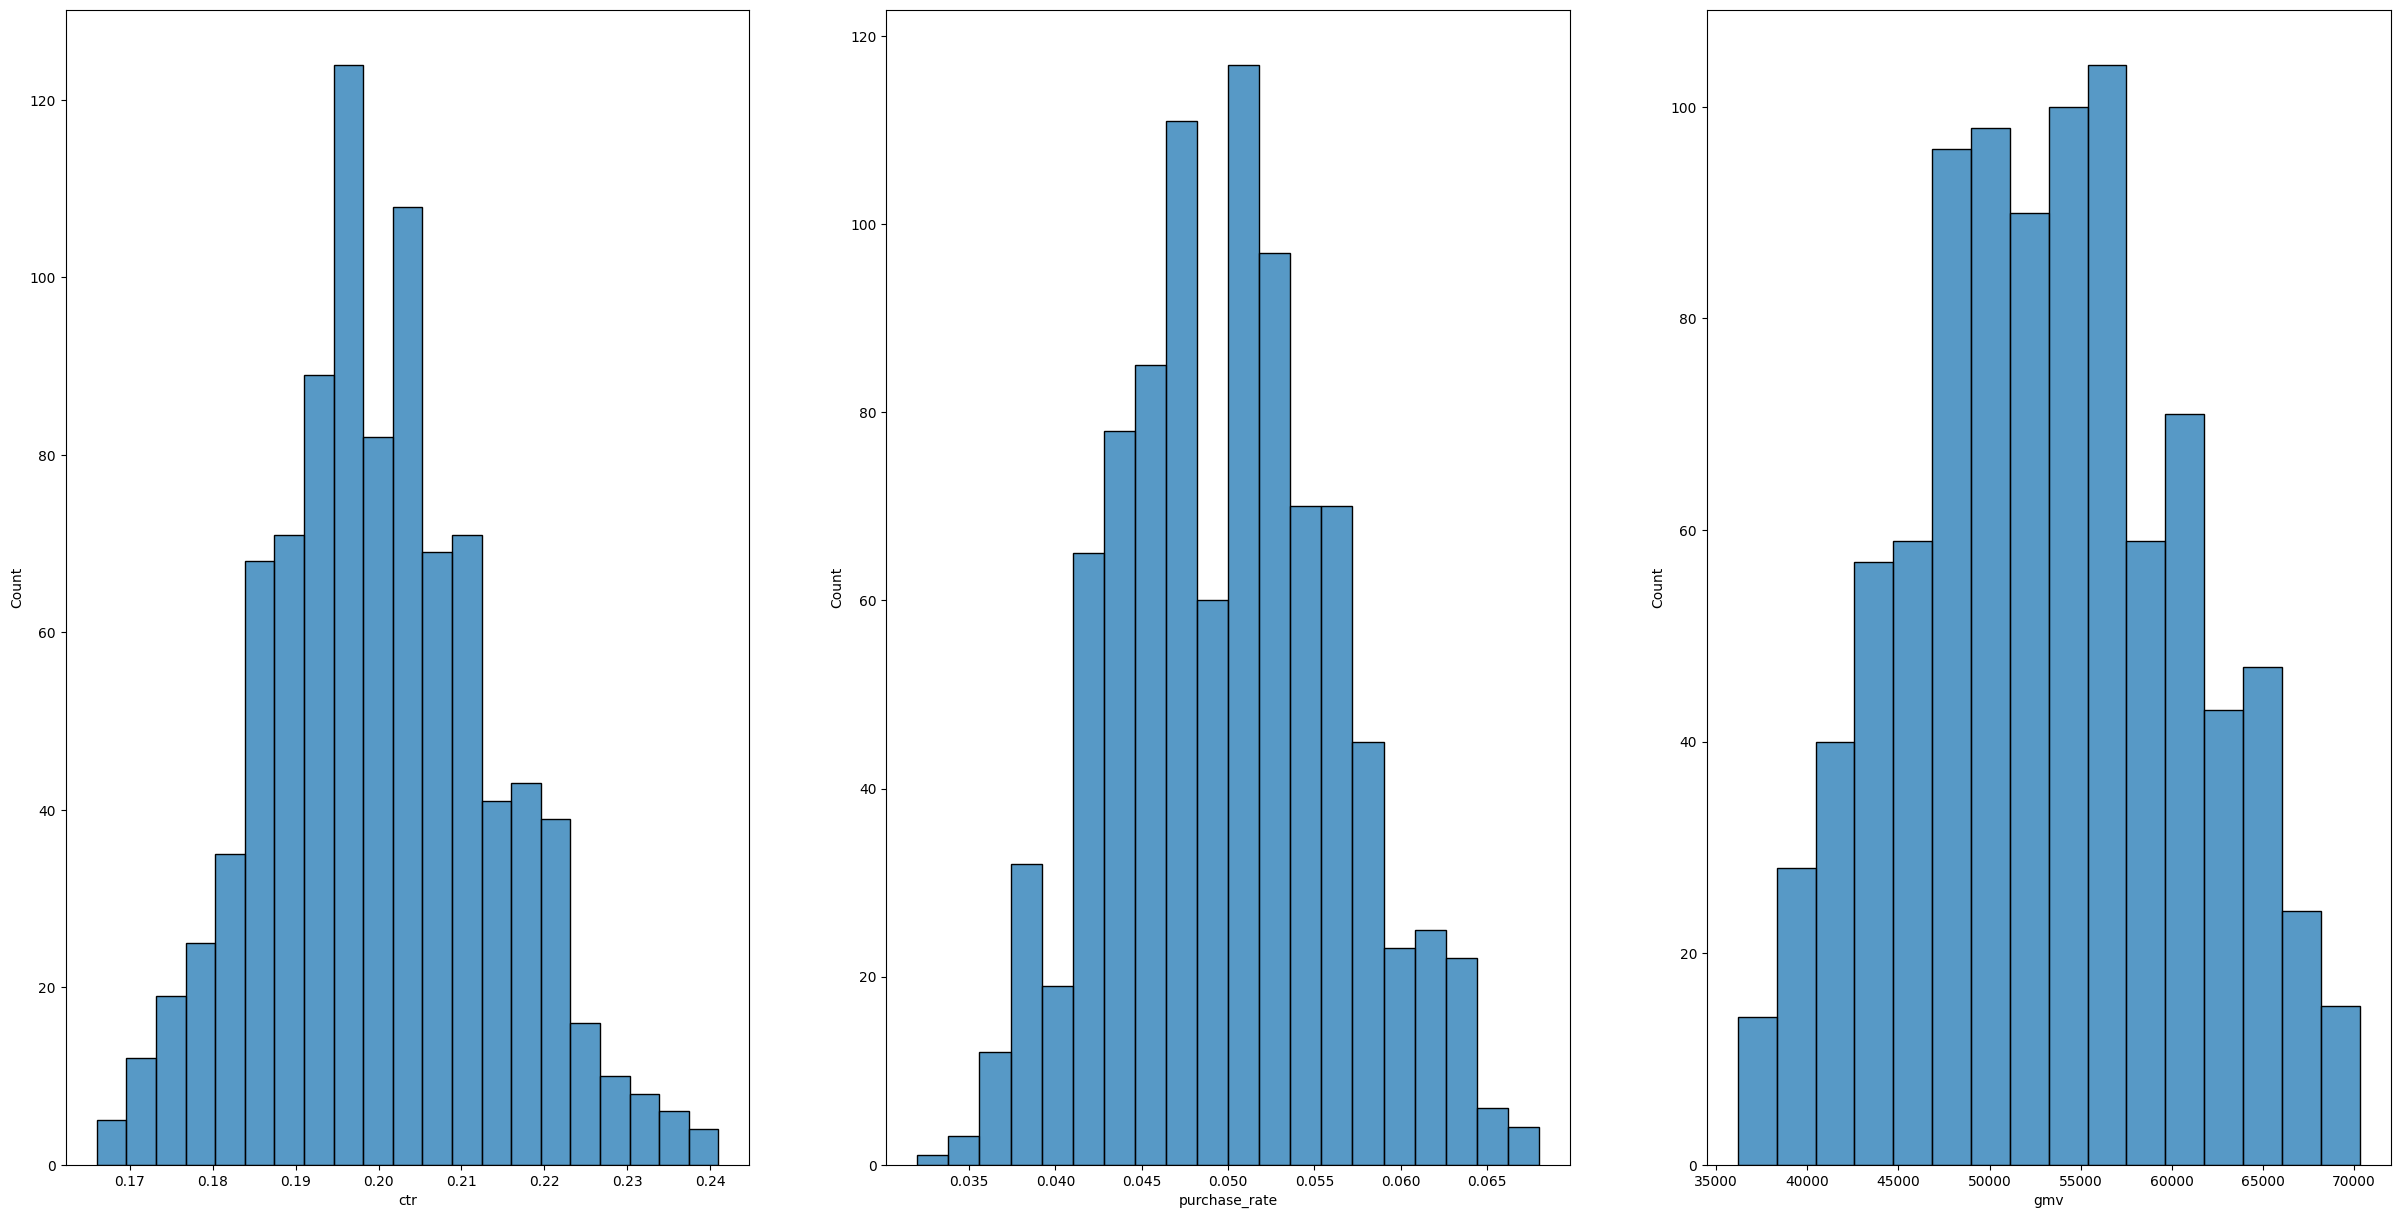

In [31]:
# Посмотрим сколько товаров в каждой выборке были кликнуты
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=cleaned_a["ctr"], ax=axes[0])

sns.histplot(data=cleaned_a["purchase_rate"], ax=axes[1])

sns.histplot(data=cleaned_a["gmv"], ax=axes[2])

plt.show()

In [32]:
# Для sample_b
for i in check_columns:
    shapiro_test(x=cleaned_b[i], name_feat=i)

ctr нормальное распределение
purchase_rate не нормальное распределение
gmv не нормальное распределение


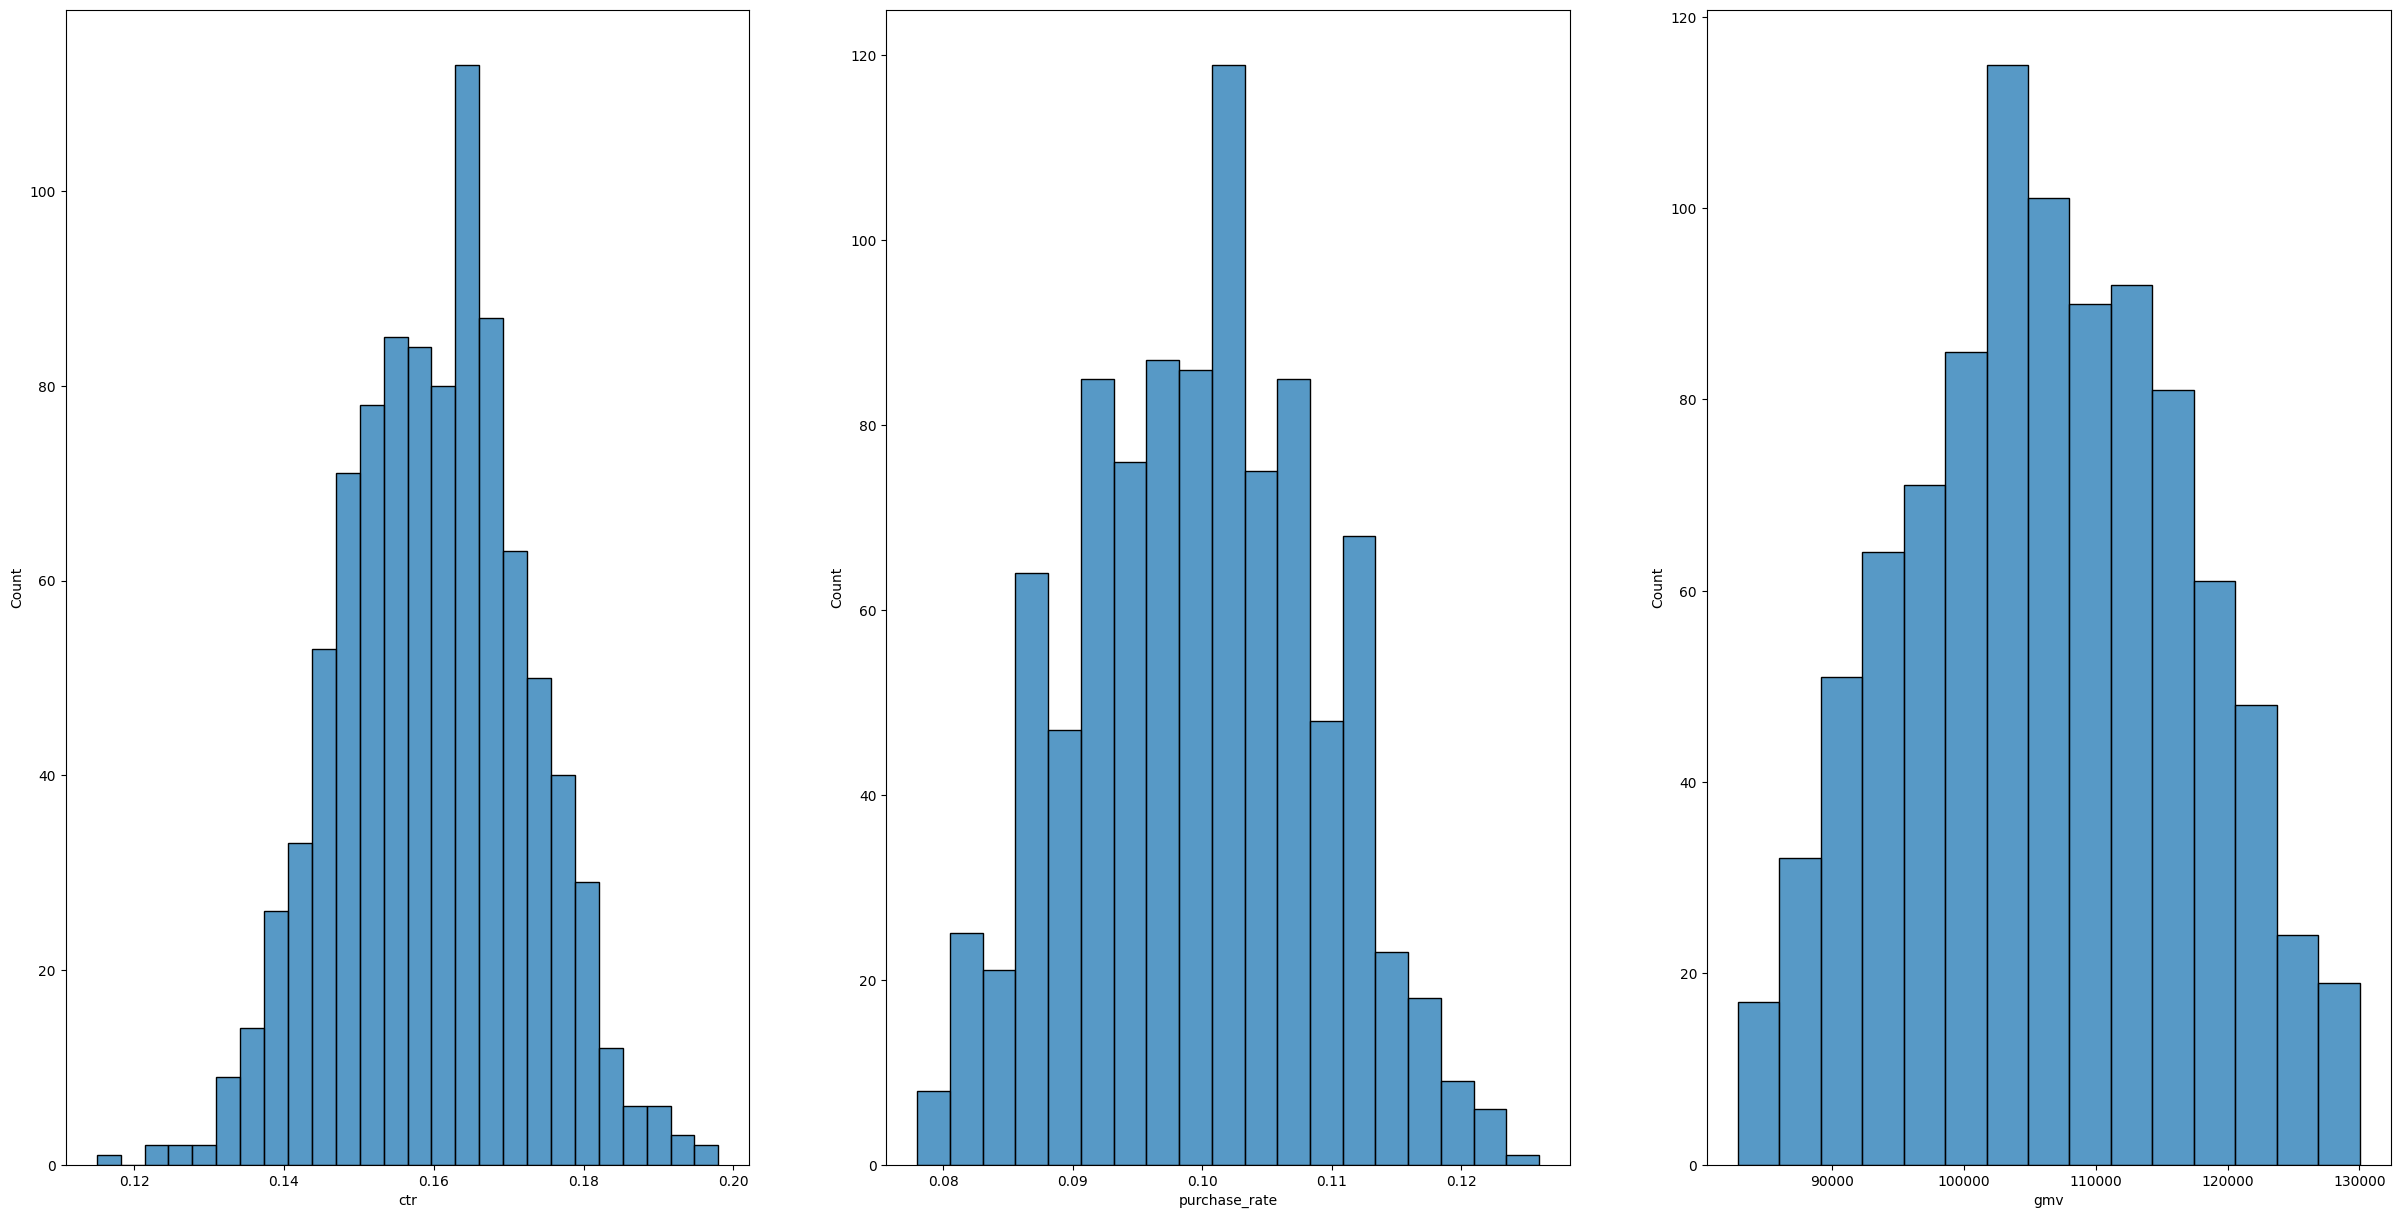

In [33]:
# Посмотрим сколько товаров в каждой выборке были кликнуты
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=cleaned_b["ctr"], ax=axes[0])

sns.histplot(data=cleaned_b["purchase_rate"], ax=axes[1])

sns.histplot(data=cleaned_b["gmv"], ax=axes[2])

plt.show()

In [34]:
# Для sample_c
for i in check_columns:
    shapiro_test(x=cleaned_c[i], name_feat=i)

ctr нормальное распределение
purchase_rate не нормальное распределение
gmv не нормальное распределение


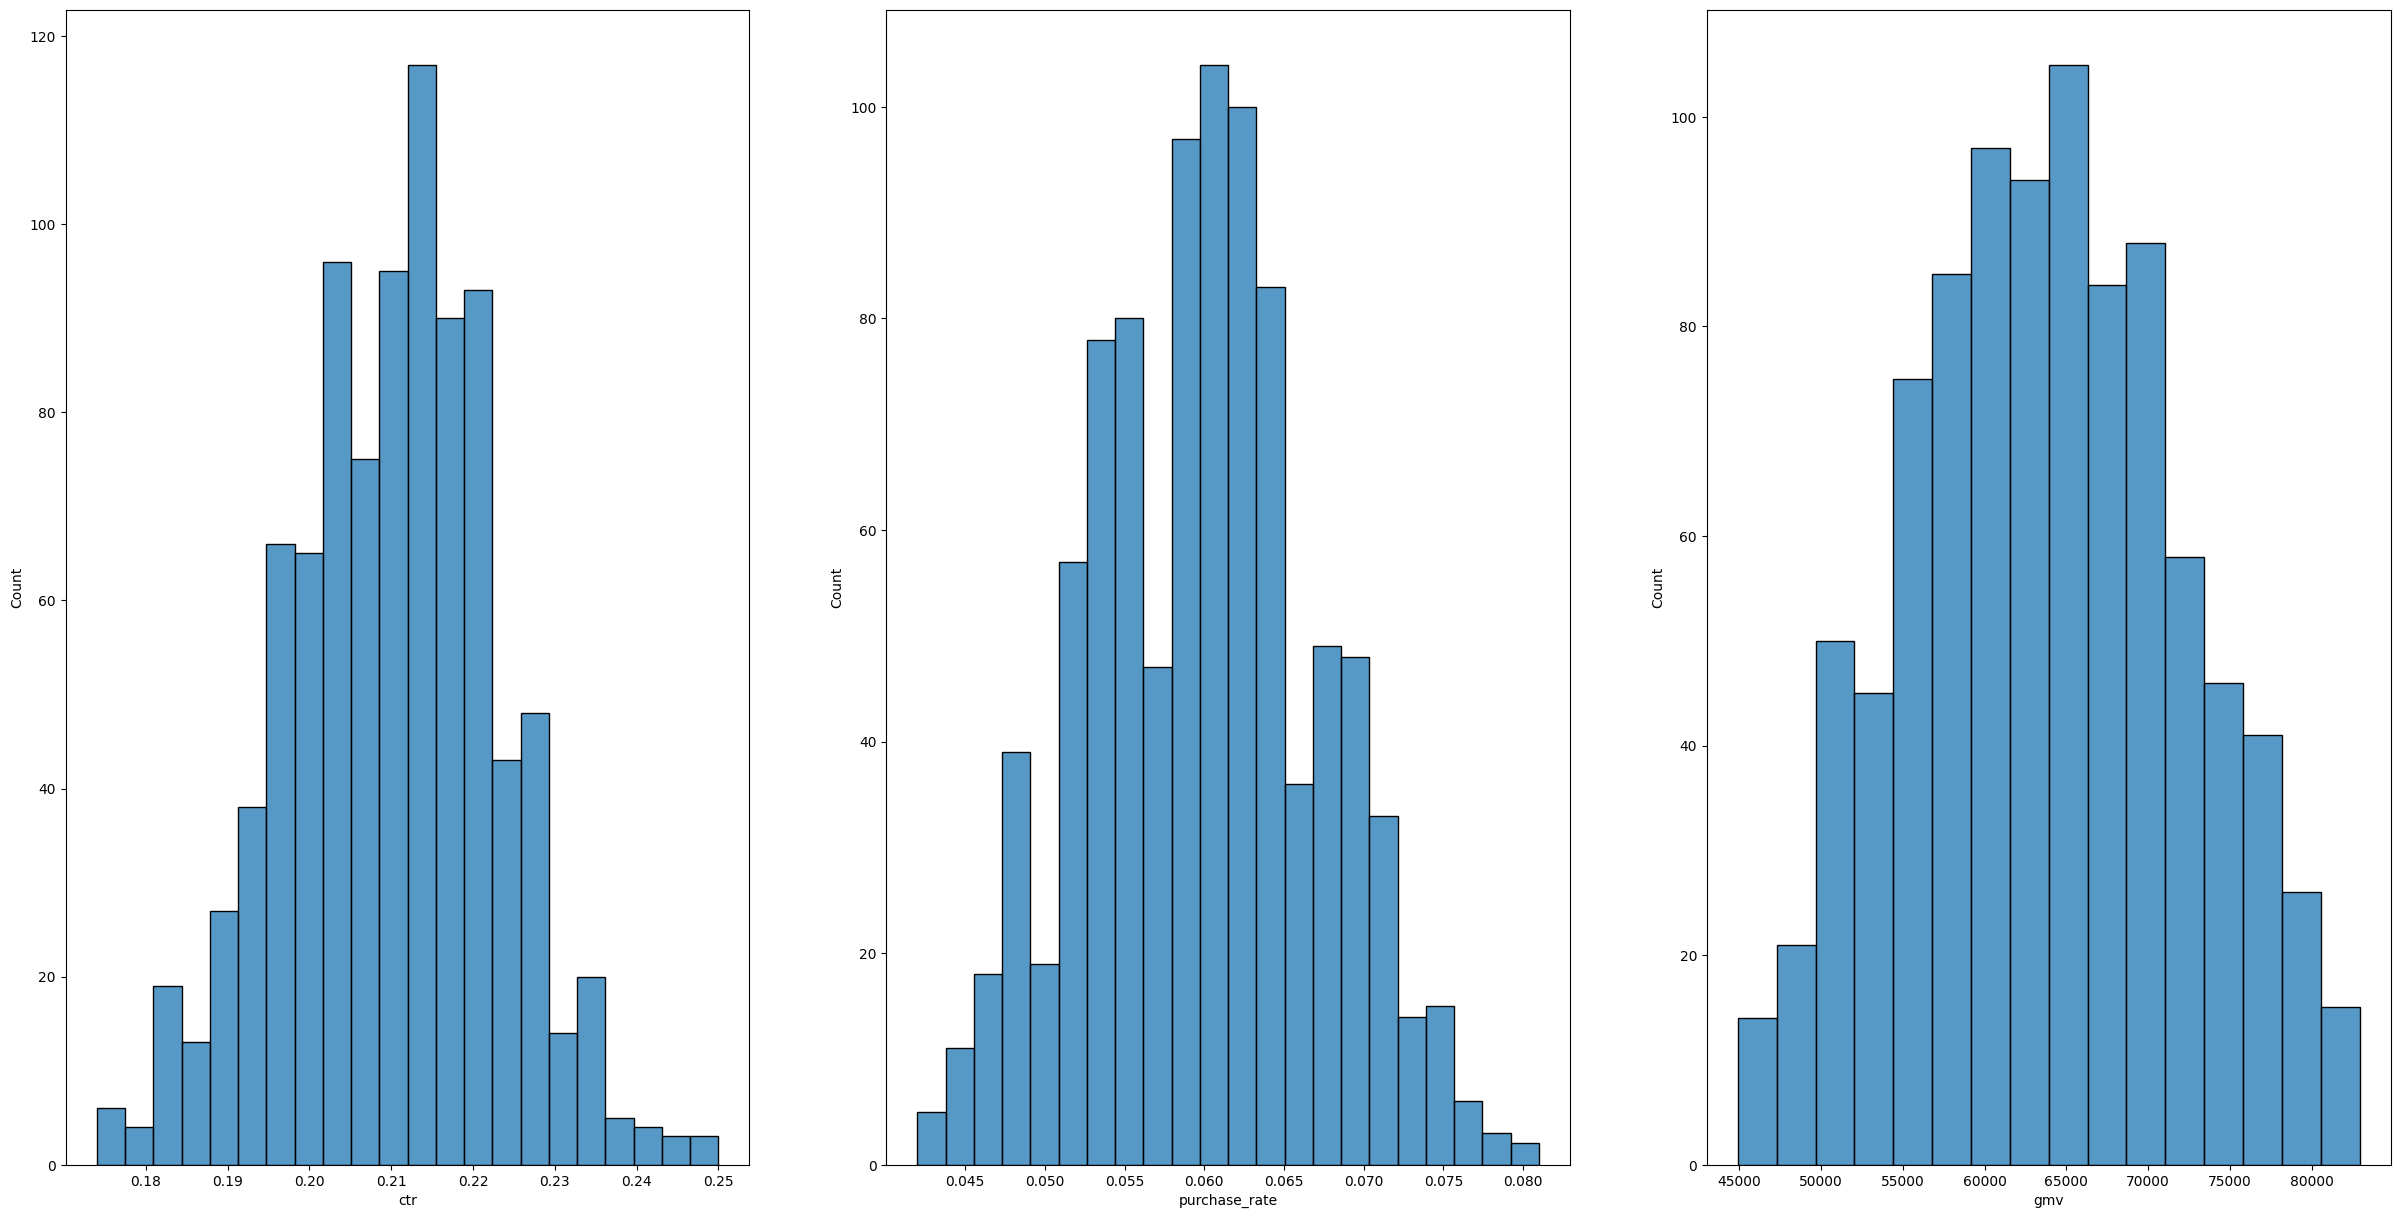

In [35]:
# Посмотрим сколько товаров в каждой выборке были кликнуты
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.histplot(data=cleaned_c["ctr"], ax=axes[0])

sns.histplot(data=cleaned_c["purchase_rate"], ax=axes[1])

sns.histplot(data=cleaned_c["gmv"], ax=axes[2])

plt.show()

> Нормаааально.

----
#### Начнем уже тестировать выборки и гипотезы.
----


##### Тест равенства долей для A и C групп по всем метрикам.

Для сравнения CTR (click-through rate) в двух выборках, когда распределение одной из них не является нормальным, можно использовать непараметрические тесты, такие как тест Манна-Уитни или тест Колмогорова-Смирнова. В нашем случае:
- CTR(A) - не нормальное распределение
- CTR(C) - нормальное распределение

In [36]:
# Проверяем гипотезу о равенстве CTR
U, p = mannwhitneyu(bach_a["ctr"], bach_c["ctr"])
if p < 0.05:
    print("Различия статистически значимы")
else:
    print("Различия не являются статистически значимыми")

Различия статистически значимы


То же самое и для purchase_rate
- purchase_rate(A) - не нормальное распределение
- purchase_rate(C) - не нормальное распределение

In [37]:
# Проверяем гипотезу о равенстве CTR
U, p = mannwhitneyu(bach_a["purchase_rate"], bach_c["purchase_rate"])
if p < 0.05:
    print("Различия статистически значимы")
else:
    print("Различия не являются статистически значимыми")

Различия статистически значимы


И для gmv та же история
- gmv(A) - не нормальное распределение
- gmv(C) - не нормальное распределение

In [38]:
# Проверяем гипотезу о равенстве CTR
U, p = mannwhitneyu(bach_a["gmv"], bach_c["gmv"])
if p < 0.05:
    print("Различия статистически значимы")
else:
    print("Различия не являются статистически значимыми")

Различия статистически значимы


----
#### Вывод по АА сплиту.

По всем метрикам группы А и С имеют значимые статистические различия, что в контексте АВА теста может говорить о том, что возможен один из данных вариантов или их комбинация:

- Разбиение контрольной группы А на АА было произведено не корректно (наиболее вероятный вариант).
- Сбор информации был закончен раньше чем распределения сплитов сошлись (что врядли если обратить внимание на суммарное колличество в пулле исследования).

----

----
##### Тест равенства долей для A и B групп по всем метрикам.


Для сравнения CTR (click-through rate) в двух выборках, когда распределение одной из них не является нормальным, можно использовать непараметрические тесты, такие как тест Манна-Уитни или тест Колмогорова-Смирнова. В нашем случае:
- CTR(A) - не нормальное распределение
- CTR(B) - нормальное распределение

In [47]:
# Проверяем гипотезу о равенстве CTR
U, p = mannwhitneyu(bach_a["ctr"], bach_b["ctr"], alternative="less")
if p < 0.05:
    print("Различия статистически значимы, B-сплит превосходит А")
else:
    print("Различия не являются статистически значимыми В-сплит не превосходит А")

Различия не являются статистически значимыми В-сплит не превосходит А


То же самое и для purchase_rate
- purchase_rate(A) - не нормальное распределение
- purchase_rate(B) - не нормальное распределение

In [48]:
# Проверяем гипотезу о равенстве CTR
U, p = mannwhitneyu(
    bach_a["purchase_rate"], bach_b["purchase_rate"], alternative="less"
)
if p < 0.05:
    print("Различия статистически значимы, B-сплит превосходит А")
else:
    print("Различия не являются статистически значимыми В-сплит не превосходит А")

Различия статистически значимы, B-сплит превосходит А


И для gmv та же история
- gmv(A) - не нормальное распределение
- gmv(B) - не нормальное распределение

In [49]:
# Проверяем гипотезу о равенстве CTR
U, p = mannwhitneyu(bach_a["gmv"], bach_b["gmv"], alternative="less")
if p < 0.05:
    print("Различия статистически значимы, B-сплит превосходит А")
else:
    print("Различия не являются статистически значимыми В-сплит не превосходит А")

Различия статистически значимы, B-сплит превосходит А


----
#### Вывод по АB сплиту.

По всем метрикам группы А и B имеют значимые статистические различия, что в контексте АВА теста может говорить о том что tretment-эффект имеет место быть (мы проводили в данном случае односторонние тесты для выявления превосходства). 

НО! так как АА сплиты показали расхождения в тестах мы не можем быть уверенны, что АВА тест был проведен корректно.


----